In [1]:
import os

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras import layers
from tensorflow.keras import losses

import tensorflow as tf

In [2]:
def collect_data_from_directory(path):
    files = os.listdir(path)
    df = pd.DataFrame()    
    for file in files:
        partial = pd.read_csv(os.path.join(path, file)).drop(['title', 'url'], axis=1).dropna()
        df = pd.concat([df,partial],ignore_index=True)
    return df        

In [3]:
df = collect_data_from_directory('./data/news_with_directions/twitter/')

In [4]:
df.sort_values('date', axis=0, ascending=True, inplace=True, kind='quicksort', na_position='last', ignore_index=True, key=None)

In [5]:
df

,date,text,direction
0,2015-10-22 13:33:00,Bitcoin Groups and Law Enforcement Unite to Fo...,2.0
1,2015-10-22 14:39:00,Prominent #Bitcoin Industry Players Form ‘#Blo...,2.0
2,2015-10-22 14:43:00,CoinDesk's New BitLicense Report Released Toda...,2.0
3,2015-10-22 15:01:00,Australia's government is set to review how th...,2.0
4,2015-10-22 15:02:00,Bitcoin Startup Abra Moves to Launch Mobile Re...,2.0
...,...,...,...
49343,2020-06-26 21:47:00,Drinks in Quarantine - Funding BTC Development...,2.0
49344,2020-06-26 21:56:00,A popular narrative says that the actions take...,2.0
49345,2020-06-26 22:17:00,Consumer advocacy group @Public_Citizen is try...,2.0
49346,2020-06-26 22:35:00,Yield Farming Pool Concept May Solidify Ethere...,2.0


<AxesSubplot:>

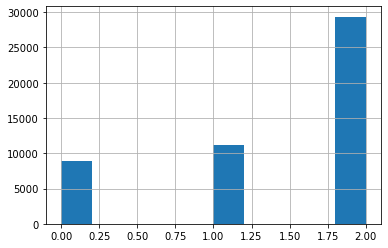

In [6]:
df['direction'].hist()

[]

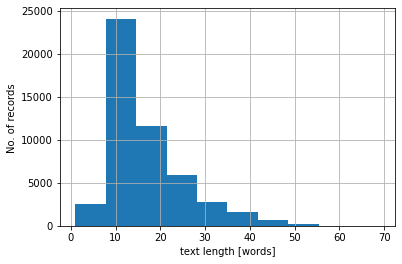

In [7]:
df['text'].map(lambda x : len(x.split())).hist()
plt.gca().set(ylabel='No. of records', xlabel='text length [words]')
plt.plot()

## Simple LSTM 

In [8]:
x = df['text']
y = df['direction']

x_train, x_test = train_test_split(x, shuffle=True, test_size=0.25)
y_train, y_test = train_test_split(y, shuffle=True, test_size=0.25)

In [9]:
max_features=1000
sequence_length = 40
embedding_dim = 128

In [10]:
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=max_features,
    output_sequence_length=sequence_length
    )
encoder.adapt(x_train.values)

x_train_vec = encoder(x_train)
x_test_vec = encoder(x_test)

In [11]:
y_train_oh = tf.one_hot(y_train, 3)
y_test_oh = tf.one_hot(y_test, 3)

In [12]:
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.LSTM(32, recurrent_dropout=0.5, dropout=0.5),
  layers.Dense(32),
  layers.Dropout(0.25),
  layers.Dense(3, activation='softmax')
])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         128128    
_________________________________________________________________
lstm (LSTM)                  (None, 32)                20608     
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 99        
Total params: 149,891
Trainable params: 149,891
Non-trainable params: 0
_________________________________________________________________


In [14]:
model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [15]:
history = model.fit(x_train_vec, y_train_oh, validation_data=(x_test_vec, y_test_oh), batch_size=32, epochs=2 )

Epoch 1/2
1157/1157 [==============================] - 189s 158ms/step - loss: 0.9670 - categorical_accuracy: 0.5875 - val_loss: 0.9508 - val_categorical_accuracy: 0.5974
Epoch 2/2
1157/1157 [==============================] - 179s 155ms/step - loss: 0.9593 - categorical_accuracy: 0.5913 - val_loss: 0.9507 - val_categorical_accuracy: 0.5974


## Series

In [16]:
series = df['direction'].values

In [17]:
steps_num = 20

In [18]:
def generate_series_data(data, steps_num):
    dim1 = int(data.shape[0] / steps_num)
    dim2 = steps_num
    return np.reshape(data[:dim1*dim2], (dim1, dim2))
    
def generate_series_data2(data, steps_num):
    res = []
    for i in range(0, series.shape[0] - steps_num):
        res.append(series[i:i+steps_num])
    return np.array(res)    

In [19]:
series = generate_series_data2(series, steps_num+1)

train_size = int(0.8*series.shape[0])
train = series[:train_size]
np.random.shuffle(train)
test = series[train_size:]

train = tf.one_hot(train, 3)
test = tf.one_hot(test, 3)

x_train, y_train = train[:, :steps_num], train[:, -1]
x_test, y_test = test[:, :steps_num], test[:, -1]

In [20]:
model = tf.keras.Sequential([
  layers.Flatten(input_shape=[steps_num, 3]),
  layers.Dense(16),
  layers.Dropout(0.25),
  layers.Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=32, epochs=4)

Epoch 1/4
1234/1234 [==============================] - 5s 4ms/step - loss: 0.6445 - categorical_accuracy: 0.7492 - val_loss: 0.5338 - val_categorical_accuracy: 0.8219
Epoch 2/4
1234/1234 [==============================] - 4s 3ms/step - loss: 0.4820 - categorical_accuracy: 0.8494 - val_loss: 0.5295 - val_categorical_accuracy: 0.8239
Epoch 3/4
1234/1234 [==============================] - 4s 3ms/step - loss: 0.4756 - categorical_accuracy: 0.8507 - val_loss: 0.5310 - val_categorical_accuracy: 0.8206
Epoch 4/4
1234/1234 [==============================] - 4s 4ms/step - loss: 0.4731 - categorical_accuracy: 0.8510 - val_loss: 0.5324 - val_categorical_accuracy: 0.8223


In [21]:
model_rnn = tf.keras.Sequential([
  layers.SimpleRNN(32, input_shape=[steps_num, 3], dropout=0.5),
  layers.Dense(16),
  layers.Dropout(0.25),
  layers.Dense(3, activation='softmax')
])

model_rnn.compile(optimizer='adam', loss='categorical_crossentropy',metrics=[tf.keras.metrics.CategoricalAccuracy()])
model_rnn.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=32, epochs=4)


Epoch 1/4
1234/1234 [==============================] - 19s 14ms/step - loss: 0.6686 - categorical_accuracy: 0.7377 - val_loss: 0.5810 - val_categorical_accuracy: 0.7823
Epoch 2/4
1234/1234 [==============================] - 17s 14ms/step - loss: 0.5907 - categorical_accuracy: 0.7896 - val_loss: 0.5760 - val_categorical_accuracy: 0.7827
Epoch 3/4
1234/1234 [==============================] - 28s 23ms/step - loss: 0.5823 - categorical_accuracy: 0.7968 - val_loss: 0.5745 - val_categorical_accuracy: 0.7860
Epoch 4/4
1234/1234 [==============================] - 28s 23ms/step - loss: 0.5795 - categorical_accuracy: 0.7972 - val_loss: 0.5594 - val_categorical_accuracy: 0.8018
